<a href="https://colab.research.google.com/github/paul821/all-star-predictor/blob/main/allstar_fin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Purpose

The All star game is painted as a popularity contest and that there are way too many wrong choices (either snubs or undeserving players). Is this actually the case?
Unlike the Cy Young or the MVP races, or game predicting or World Series predictions, there aren't that many predictions for the MLB All Star.

This project serves to use data analytics and machine learning on all star data, focusing on two things:

First, identifying which factors contribute the most to MLB All Star selection, focusing on certain comparisons
- classic stats vs sabermetrics
- performance vs popularity
- past season(s) performance vs this year performance
- overrated players, overpaid players, underrated players, snubs

Second, creating a model that attempts to either predict or classify a player based on the odds of making it to the All Star roster.

## Data import and preprocessing

##Lahman DB

In [ ]:
import pandas as pd

allstar = pd.read_csv('https://raw.githubusercontent.com/paul821/all-star-predictor/data/AllstarFull.csv')
print(allstar.columns)
batting = pd.read_csv('https://raw.githubusercontent.com/paul821/all-star-predictor/data/Batting.csv')
print(batting.columns)
fielding = pd.read_csv('https://raw.githubusercontent.com/paul821/all-star-predictor/data/Fielding.csv')
print(fielding.columns)
people = pd.read_csv('https://raw.githubusercontent.com/paul821/all-star-predictor/data/People.csv')
print(people.columns)
pitching = pd.read_csv('https://raw.githubusercontent.com/paul821/all-star-predictor/data/Pitching.csv')
print(pitching.columns)
salaries = pd.read_csv('https://raw.githubusercontent.com/paul821/all-star-predictor/data/Salaries.csv')
print(salaries.columns)
teams = pd.read_csv('https://raw.githubusercontent.com/paul821/all-star-predictor/data/Teams.csv')
print(teams.columns)


Index(['playerID', 'yearID', 'gameNum', 'gameID', 'teamID', 'lgID', 'GP',
       'startingPos'],
      dtype='object')
Index(['playerID', 'yearID', 'stint', 'teamID', 'lgID', 'G', 'AB', 'R', 'H',
       '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH',
       'SF', 'GIDP'],
      dtype='object')
Index(['playerID', 'yearID', 'stint', 'teamID', 'lgID', 'POS', 'G', 'GS',
       'InnOuts', 'PO', 'A', 'E', 'DP', 'PB', 'WP', 'SB', 'CS', 'ZR'],
      dtype='object')
Index(['playerID', 'birthYear', 'birthMonth', 'birthDay', 'birthCountry',
       'birthState', 'birthCity', 'deathYear', 'deathMonth', 'deathDay',
       'deathCountry', 'deathState', 'deathCity', 'nameFirst', 'nameLast',
       'nameGiven', 'weight', 'height', 'bats', 'throws', 'debut', 'finalGame',
       'retroID', 'bbrefID'],
      dtype='object')
Index(['playerID', 'yearID', 'stint', 'teamID', 'lgID', 'W', 'L', 'G', 'GS',
       'CG', 'SHO', 'SV', 'IPouts', 'H', 'ER', 'HR', 'BB', 'SO', 'BAOpp',
       'ERA'

- have to delete pre live ball era
- have to delete years w/o all star
- have to delete players with multiple stints (traded teams mid season)
- fan voting started from 1970

In [ ]:
allstar = allstar.loc[allstar["yearID"] >= 1970]
batting = batting.loc[batting["yearID"] >= 1970]
fielding = fielding.loc[fielding["yearID"] >= 1970]
pitching = pitching.loc[pitching["yearID"] >= 1970]
salaries = salaries.loc[salaries["yearID"] >= 1970]
teams = teams.loc[teams["yearID"] >= 1970]

removing useless columns and deleting player stats with multiple stints

In [ ]:
allstar = allstar.drop(columns=['gameNum', 'gameID', 'GP'])
allstar['isAS'] = 1
batting = batting.drop_duplicates(subset=['playerID', 'yearID'], keep=False)
fielding = fielding.drop_duplicates(subset=['playerID', 'yearID'], keep=False)
pitching = pitching.drop_duplicates(subset=['playerID', 'yearID'], keep=False)
people = people.drop(columns=['birthYear', 'birthMonth', 'birthDay', 'birthCountry',
       'birthState', 'birthCity', 'deathYear', 'deathMonth', 'deathDay',
       'deathCountry', 'deathState', 'deathCity','bats', 'throws', 'debut', 'finalGame'])

rookie eligibility is 130 abs or 50 IPs - what about RPs?

FG says 154 and 60.1 IPs

create BA column

In [ ]:
batting = batting.loc[batting['AB']>=154]
pitching = pitching.loc[pitching['IPouts']>=183]

batting['BA'] = batting['H']/batting['AB']
batting['OBP'] = (batting['H']+batting['BB']+batting['HBP'])/(batting['AB']+batting['BB']+batting['SF']+batting['HBP'])
batting['SLG'] = (batting['H']+batting['2B']+2*batting['3B']+3*batting['HR'])/batting['AB']
batting['OPS'] = batting['OBP'] + batting['SLG']

status check to see what columns there are now. will be doing this quite frequently in the data cleaning process.

In [ ]:
listofcsv = [allstar, batting, fielding, people, pitching, salaries, teams]
for i in listofcsv:
  print(i.columns)

Index(['playerID', 'yearID', 'teamID', 'lgID', 'startingPos', 'isAS'], dtype='object')
Index(['playerID', 'yearID', 'stint', 'teamID', 'lgID', 'G', 'AB', 'R', 'H',
       '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH',
       'SF', 'GIDP', 'BA', 'OBP', 'SLG', 'OPS'],
      dtype='object')
Index(['playerID', 'yearID', 'stint', 'teamID', 'lgID', 'POS', 'G', 'GS',
       'InnOuts', 'PO', 'A', 'E', 'DP', 'PB', 'WP', 'SB', 'CS', 'ZR'],
      dtype='object')
Index(['playerID', 'nameFirst', 'nameLast', 'nameGiven', 'weight', 'height',
       'retroID', 'bbrefID'],
      dtype='object')
Index(['playerID', 'yearID', 'stint', 'teamID', 'lgID', 'W', 'L', 'G', 'GS',
       'CG', 'SHO', 'SV', 'IPouts', 'H', 'ER', 'HR', 'BB', 'SO', 'BAOpp',
       'ERA', 'IBB', 'WP', 'HBP', 'BK', 'BFP', 'GF', 'R', 'SH', 'SF', 'GIDP'],
      dtype='object')
Index(['yearID', 'teamID', 'lgID', 'playerID', 'salary'], dtype='object')
Index(['yearID', 'lgID', 'teamID', 'franchID', 'divID', 'Rank', 'G'

dropping unnecessary columns - will be merging a lot of these tables and there are a lot of overlapping columns

In [ ]:
teams = teams.drop(columns=['Rank','DivWin', 'WCWin', 'LgWin', 'WSWin','R','AB','H', '2B',
       '3B', 'HR', 'BB', 'SO', 'SB', 'CS', 'HBP', 'SF', 'RA', 'ER', 'ERA',
       'CG', 'SHO', 'SV', 'IPouts', 'HA', 'HRA', 'BBA', 'SOA', 'E', 'DP', 'FP'])


time to join all the tables

##Joining Tables

In [ ]:
batting_merged = pd.merge(batting, people, left_on='playerID', right_on='playerID', how='left')
fielding_merged = pd.merge(fielding, people, left_on='playerID', right_on='playerID', how='left')
pitching_merged = pd.merge(pitching, people, left_on='playerID', right_on='playerID', how='left')
batting_merged.head


<bound method NDFrame.head of         playerID  yearID  stint teamID lgID    G   AB    R    H  2B  ...  \
0      aaronha01    1970      1    ATL   NL  150  516  103  154  26  ...   
1       ageeto01    1970      1    NYN   NL  153  636  107  182  30  ...   
2      allenbe01    1970      1    WS2   AL  104  261   31   61   7  ...   
3      allendi01    1970      1    SLN   NL  122  459   88  128  17  ...   
4      alleyge01    1970      1    PIT   NL  121  426   46  104  16  ...   
...          ...     ...    ...    ...  ...  ...  ...  ...  ...  ..  ...   
16305  wynnsau01    2022      1    SFN   NL   66  162   14   42   7  ...   
16306  yastrmi01    2022      1    SFN   NL  148  485   73  104  31  ...   
16307  yelicch01    2022      1    MIL   NL  154  575   99  145  25  ...   
16308  yepezju01    2022      1    SLN   NL   76  253   27   64  13  ...   
16309  zavalse01    2022      1    CHA   AL   61  178   22   48  14  ...   

            OBP       SLG       OPS  nameFirst     nameLa

In [ ]:
batting_allstar = pd.merge(batting_merged, allstar, left_on = ['playerID','yearID'], right_on=['playerID', 'yearID'], how='left').drop(columns=['teamID_y', 'lgID_y'])
batting_allstar.rename(columns = {'teamID_x':'teamID', 'lgID_x':'lgID'}, inplace = True)
pitching_allstar = pd.merge(pitching_merged, allstar, left_on = ['playerID','yearID'], right_on=['playerID', 'yearID'], how='left').drop(columns=['teamID_y', 'lgID_y'])
pitching_allstar.rename(columns = {'teamID_x':'teamID', 'lgID_x':'lgID'}, inplace = True)

print(batting_allstar.columns)

Index(['playerID', 'yearID', 'stint', 'teamID', 'lgID', 'G', 'AB', 'R', 'H',
       '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH',
       'SF', 'GIDP', 'BA', 'OBP', 'SLG', 'OPS', 'nameFirst', 'nameLast',
       'nameGiven', 'weight', 'height', 'retroID', 'bbrefID', 'startingPos',
       'isAS'],
      dtype='object')


In [ ]:
batting_salaries = pd.merge(batting_allstar, salaries, left_on = ['playerID','yearID'], right_on=['playerID', 'yearID'], how='left').drop(columns=['teamID_y', 'lgID_y'])
batting_salaries.rename(columns = {'teamID_x':'teamID', 'lgID_x':'lgID'}, inplace = True)
pitching_salaries = pd.merge(pitching_allstar, salaries, left_on = ['playerID','yearID'], right_on=['playerID', 'yearID'], how='left').drop(columns=['teamID_y', 'lgID_y'])
pitching_salaries.rename(columns = {'teamID_x':'teamID', 'lgID_x':'lgID'}, inplace = True)

In [ ]:
batting_full = pd.merge(batting_salaries, teams, left_on=['yearID','teamID'],right_on=['yearID','teamID'], how='left')#.drop(columns=['lgID_y', 'G_y'])
batting_full.rename(columns = {'lgID_x':'lgID', 'G_x':'G'}, inplace = True)
pitching_full = pd.merge(pitching_salaries, teams, left_on=['yearID','teamID'],right_on=['yearID','teamID'], how='left')#.drop(columns=['lgID_y', 'G_y', 'W_y', 'L_y'])
pitching_full.rename(columns = {'lgID_x':'lgID', 'W_x':'W', 'L_x':'L', 'G_x':'G'}, inplace = True)
print(batting_full.columns)

Index(['playerID', 'yearID', 'stint', 'teamID', 'lgID', 'G', 'AB', 'R', 'H',
       '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH',
       'SF', 'GIDP', 'BA', 'OBP', 'SLG', 'OPS', 'nameFirst', 'nameLast',
       'nameGiven', 'weight', 'height', 'retroID', 'bbrefID', 'startingPos',
       'isAS', 'salary', 'lgID_y', 'franchID', 'divID', 'G_y', 'Ghome', 'W',
       'L', 'name', 'park', 'attendance', 'BPF', 'PPF', 'teamIDBR',
       'teamIDlahman45', 'teamIDretro'],
      dtype='object')


In [ ]:
print(pitching_full.columns)

Index(['playerID', 'yearID', 'stint', 'teamID', 'lgID', 'W', 'L', 'G', 'GS',
       'CG', 'SHO', 'SV', 'IPouts', 'H', 'ER', 'HR', 'BB', 'SO', 'BAOpp',
       'ERA', 'IBB', 'WP', 'HBP', 'BK', 'BFP', 'GF', 'R', 'SH', 'SF', 'GIDP',
       'nameFirst', 'nameLast', 'nameGiven', 'weight', 'height', 'retroID',
       'bbrefID', 'startingPos', 'isAS', 'salary', 'lgID_y', 'franchID',
       'divID', 'G_y', 'Ghome', 'W_y', 'L_y', 'name', 'park', 'attendance',
       'BPF', 'PPF', 'teamIDBR', 'teamIDlahman45', 'teamIDretro'],
      dtype='object')


##Fangraphs data

##Importing and basic cleaning

need saber data

In [ ]:
!pip install pybaseball

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.0/420.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 342.2/342.2 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 15.6 MB/s eta 0:00:00
  Attempting uninstall: pyjwt
    Found existing installation: PyJWT 2.3.0
    Uninstalling PyJWT-2.3.0:
      Successfully uninstalled PyJWT-2.3.0


In [ ]:
import pybaseball

from pybaseball import pitching_stats
from pybaseball import batting_stats

fpdata = pitching_stats(1970, 2022)
fbdata = batting_stats(1970, 2022)


IDfg, Season, Name, Team, WAR, K/BB, FIP, WHIP

In [ ]:
for i in range(len(fpdata.columns)):
    print(fpdata.columns[i])


IDfg
Season
Name
Team
Age
W
L
WAR
ERA
G
GS
CG
ShO
SV
BS
IP
TBF
H
R
ER
HR
BB
IBB
HBP
WP
BK
SO
GB
FB
LD
IFFB
Balls
Strikes
Pitches
RS
IFH
BU
BUH
K/9
BB/9
K/BB
H/9
HR/9
AVG
WHIP
BABIP
LOB%
FIP
GB/FB
LD%
GB%
FB%
IFFB%
HR/FB
IFH%
BUH%
Starting
Start-IP
Relieving
Relief-IP
RAR
Dollars
tERA
xFIP
WPA
-WPA
+WPA
RE24
REW
pLI
inLI
gmLI
exLI
Pulls
WPA/LI
Clutch
FB% 2
FBv
SL%
SLv
CT%
CTv
CB%
CBv
CH%
CHv
SF%
SFv
KN%
KNv
XX%
PO%
wFB
wSL
wCT
wCB
wCH
wSF
wKN
wFB/C
wSL/C
wCT/C
wCB/C
wCH/C
wSF/C
wKN/C
O-Swing%
Z-Swing%
Swing%
O-Contact%
Z-Contact%
Contact%
Zone%
F-Strike%
SwStr%
HLD
SD
MD
ERA-
FIP-
xFIP-
K%
BB%
SIERA
RS/9
E-F
FA% (sc)
FT% (sc)
FC% (sc)
FS% (sc)
FO% (sc)
SI% (sc)
SL% (sc)
CU% (sc)
KC% (sc)
EP% (sc)
CH% (sc)
SC% (sc)
KN% (sc)
UN% (sc)
vFA (sc)
vFT (sc)
vFC (sc)
vFS (sc)
vFO (sc)
vSI (sc)
vSL (sc)
vCU (sc)
vKC (sc)
vEP (sc)
vCH (sc)
vSC (sc)
vKN (sc)
FA-X (sc)
FT-X (sc)
FC-X (sc)
FS-X (sc)
FO-X (sc)
SI-X (sc)
SL-X (sc)
CU-X (sc)
KC-X (sc)
EP-X (sc)
CH-X (sc)
SC-X (sc)
KN-X (sc)
FA-Z (sc)
FT

min IP here is 60.1 -> refer that to the beginning

In [ ]:
print(min(fpdata['IP']))

60.1


In [ ]:
fpdata = fpdata[['IDfg', 'Season', 'Name', 'Team', 'WAR', 'K/BB', 'FIP', 'WHIP']]

In [ ]:
fpdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4300 entries, 33 to 4022
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IDfg    4300 non-null   int64  
 1   Season  4300 non-null   int64  
 2   Name    4300 non-null   object 
 3   Team    4300 non-null   object 
 4   WAR     4300 non-null   float64
 5   K/BB    4300 non-null   float64
 6   FIP     4300 non-null   float64
 7   WHIP    4300 non-null   float64
dtypes: float64(4), int64(2), object(2)
memory usage: 302.3+ KB


In [ ]:
print(min(fbdata['AB']))

154


In [ ]:
for i in range(len(fbdata.columns)):
    print(fbdata.columns[i])

IDfg
Season
Name
Team
Age
G
AB
PA
H
1B
2B
3B
HR
R
RBI
BB
IBB
SO
HBP
SF
SH
GDP
SB
CS
AVG
GB
FB
LD
IFFB
Pitches
Balls
Strikes
IFH
BU
BUH
BB%
K%
BB/K
OBP
SLG
OPS
ISO
BABIP
GB/FB
LD%
GB%
FB%
IFFB%
HR/FB
IFH%
BUH%
wOBA
wRAA
wRC
Bat
Fld
Rep
Pos
RAR
WAR
Dol
Spd
wRC+
WPA
-WPA
+WPA
RE24
REW
pLI
phLI
PH
WPA/LI
Clutch
FB% (Pitch)
FBv
SL%
SLv
CT%
CTv
CB%
CBv
CH%
CHv
SF%
SFv
KN%
KNv
XX%
PO%
wFB
wSL
wCT
wCB
wCH
wSF
wKN
wFB/C
wSL/C
wCT/C
wCB/C
wCH/C
wSF/C
wKN/C
O-Swing%
Z-Swing%
Swing%
O-Contact%
Z-Contact%
Contact%
Zone%
F-Strike%
SwStr%
BsR
FA% (sc)
FT% (sc)
FC% (sc)
FS% (sc)
FO% (sc)
SI% (sc)
SL% (sc)
CU% (sc)
KC% (sc)
EP% (sc)
CH% (sc)
SC% (sc)
KN% (sc)
UN% (sc)
vFA (sc)
vFT (sc)
vFC (sc)
vFS (sc)
vFO (sc)
vSI (sc)
vSL (sc)
vCU (sc)
vKC (sc)
vEP (sc)
vCH (sc)
vSC (sc)
vKN (sc)
FA-X (sc)
FT-X (sc)
FC-X (sc)
FS-X (sc)
FO-X (sc)
SI-X (sc)
SL-X (sc)
CU-X (sc)
KC-X (sc)
EP-X (sc)
CH-X (sc)
SC-X (sc)
KN-X (sc)
FA-Z (sc)
FT-Z (sc)
FC-Z (sc)
FS-Z (sc)
FO-Z (sc)
SI-Z (sc)
SL-Z (sc)
CU-Z (sc)
KC-Z (sc)
EP-

only select things i will use

IDfg, Season, Name, Team, BB/K, OPS, ISO, BABIP, wSB, wRC, wOBA, WRC+, off, def, war

In [ ]:
fbdata = fbdata[['IDfg', 'Season', 'BB/K', 'OPS', 'ISO', 'BABIP', 'wOBA', 'wRC+', 'Off', 'Def', 'WAR']]

In [ ]:
fbdata.head

<bound method NDFrame.head of          IDfg  Season  BB/K    OPS    ISO  BABIP   wOBA  wRC+    Off   Def  \
0        1109    2002  4.21  1.381  0.429  0.330  0.544   244  108.9  -2.0   
2        1109    2001  1.90  1.379  0.536  0.266  0.537   235  118.0 -12.0   
1        1109    2004  5.66  1.422  0.450  0.310  0.537   233  105.7  -4.4   
32      15640    2022  0.63  1.111  0.375  0.340  0.458   207   86.1   1.1   
76    1009179    1975  2.54  0.974  0.181  0.336  0.443   176   65.6  17.3   
...       ...     ...   ...    ...    ...    ...    ...   ...    ...   ...   
6739  1010427    1993  0.91  0.654  0.056  0.295  0.295    76  -17.3 -28.5   
7387     9272    2018  0.21  0.539  0.128  0.237  0.239    46  -35.5  -7.1   
7329      595    1999  0.56  0.577  0.047  0.264  0.261    46  -44.9  -3.3   
7377      620    2002  0.38  0.564  0.067  0.254  0.247    39  -43.6  -5.4   
5932       57    1997  0.19  0.712  0.145  0.298  0.312    82  -12.9 -34.7   

       WAR  
0     12.7  
2     1

##Joining Tables

In [ ]:
from pybaseball import playerid_reverse_lookup

test = playerid_reverse_lookup([1009179], key_type='fangraphs')
#print(test['key_retro'])

print(playerid_reverse_lookup([1009179], key_type='fangraphs')['key_retro'])

Gathering player lookup table. This may take a moment.
0    morgj001
Name: key_retro, dtype: object


fg ID -> retro ID to connect

In [ ]:
fbdata1 = fbdata

fbdata1['IDretro'] = fbdata1.apply(lambda x: playerid_reverse_lookup([x['IDfg']], key_type='fangraphs')['key_retro'], axis=1)

fpdata1 = fpdata

fpdata1['IDretro'] = fpdata1.apply(lambda x: playerid_reverse_lookup([x['IDfg']], key_type='fangraphs')['key_retro'], axis=1)


In [ ]:
fbdata.head

<bound method NDFrame.head of          IDfg  Season  BB/K    OPS    ISO  BABIP   wOBA  wRC+    Off   Def  \
0        1109    2002  4.21  1.381  0.429  0.330  0.544   244  108.9  -2.0   
2        1109    2001  1.90  1.379  0.536  0.266  0.537   235  118.0 -12.0   
1        1109    2004  5.66  1.422  0.450  0.310  0.537   233  105.7  -4.4   
32      15640    2022  0.63  1.111  0.375  0.340  0.458   207   86.1   1.1   
76    1009179    1975  2.54  0.974  0.181  0.336  0.443   176   65.6  17.3   
...       ...     ...   ...    ...    ...    ...    ...   ...    ...   ...   
6739  1010427    1993  0.91  0.654  0.056  0.295  0.295    76  -17.3 -28.5   
7387     9272    2018  0.21  0.539  0.128  0.237  0.239    46  -35.5  -7.1   
7329      595    1999  0.56  0.577  0.047  0.264  0.261    46  -44.9  -3.3   
7377      620    2002  0.38  0.564  0.067  0.254  0.247    39  -43.6  -5.4   
5932       57    1997  0.19  0.712  0.145  0.298  0.312    82  -12.9 -34.7   

       WAR   IDretro  
0     12.7

In [ ]:
fbdata1.head

<bound method NDFrame.head of          IDfg  Season  BB/K    OPS    ISO  BABIP   wOBA  wRC+    Off   Def  \
0        1109    2002  4.21  1.381  0.429  0.330  0.544   244  108.9  -2.0   
2        1109    2001  1.90  1.379  0.536  0.266  0.537   235  118.0 -12.0   
1        1109    2004  5.66  1.422  0.450  0.310  0.537   233  105.7  -4.4   
32      15640    2022  0.63  1.111  0.375  0.340  0.458   207   86.1   1.1   
76    1009179    1975  2.54  0.974  0.181  0.336  0.443   176   65.6  17.3   
...       ...     ...   ...    ...    ...    ...    ...   ...    ...   ...   
6739  1010427    1993  0.91  0.654  0.056  0.295  0.295    76  -17.3 -28.5   
7387     9272    2018  0.21  0.539  0.128  0.237  0.239    46  -35.5  -7.1   
7329      595    1999  0.56  0.577  0.047  0.264  0.261    46  -44.9  -3.3   
7377      620    2002  0.38  0.564  0.067  0.254  0.247    39  -43.6  -5.4   
5932       57    1997  0.19  0.712  0.145  0.298  0.312    82  -12.9 -34.7   

       WAR   IDretro  
0     12.7

In [ ]:
batting_full.head

<bound method NDFrame.head of         playerID  yearID  stint teamID lgID    G   AB    R    H  2B  ...   W  \
0      aaronha01    1970      1    ATL   NL  150  516  103  154  26  ...  76   
1       ageeto01    1970      1    NYN   NL  153  636  107  182  30  ...  83   
2      allenbe01    1970      1    WS2   AL  104  261   31   61   7  ...  70   
3      allendi01    1970      1    SLN   NL  122  459   88  128  17  ...  76   
4      alleyge01    1970      1    PIT   NL  121  426   46  104  16  ...  89   
...          ...     ...    ...    ...  ...  ...  ...  ...  ...  ..  ...  ..   
16315  wynnsau01    2022      1    SFN   NL   66  162   14   42   7  ...  81   
16316  yastrmi01    2022      1    SFN   NL  148  485   73  104  31  ...  81   
16317  yelicch01    2022      1    MIL   NL  154  575   99  145  25  ...  86   
16318  yepezju01    2022      1    SLN   NL   76  253   27   64  13  ...  93   
16319  zavalse01    2022      1    CHA   AL   61  178   22   48  14  ...  81   

        L

In [ ]:
batting_full_fg = pd.merge(batting_full, fbdata1, left_on=['retroID','yearID'],right_on=['IDretro','Season'], how='left').drop(columns=['lgID_y', 'G_y'])


In [ ]:
print(batting_full_fg.columns)

Index(['playerID', 'yearID', 'stint', 'teamID', 'lgID', 'G', 'AB', 'R', 'H',
       '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH',
       'SF', 'GIDP', 'BA', 'OBP', 'SLG', 'OPS_x', 'nameFirst', 'nameLast',
       'nameGiven', 'weight', 'height', 'retroID', 'bbrefID', 'startingPos',
       'isAS', 'salary', 'franchID', 'divID', 'Ghome', 'W', 'L', 'name',
       'park', 'attendance', 'BPF', 'PPF', 'teamIDBR', 'teamIDlahman45',
       'teamIDretro', 'IDfg', 'Season', 'BB/K', 'OPS_y', 'ISO', 'BABIP',
       'wOBA', 'wRC+', 'Off', 'Def', 'WAR', 'IDretro'],
      dtype='object')


In [ ]:
pitching_full_fg = pd.merge(pitching_full, fpdata1, left_on=['retroID','yearID'],right_on=['IDretro','Season'], how='left').drop(columns=['lgID_y', 'G_y'])

## Bref data

##Importing and cleaning

lets get baseball ref data too! cuz fwar vs bwar you know and all

In [ ]:
from pybaseball import bwar_bat
from pybaseball import bwar_pitch

# get war stats from baseball reference
bref = bwar_bat()
brefp = bwar_pitch()


return all = true brings in more pieces of data. lets see if we will end up using them

In [ ]:
brefasdf = bwar_bat(return_all=True)
brefpasdf = bwar_pitch(return_all=True)

In [ ]:
brefasdf.columns

Index(['name_common', 'age', 'mlb_ID', 'player_ID', 'year_ID', 'team_ID',
       'stint_ID', 'lg_ID', 'PA', 'G', 'Inn', 'runs_bat', 'runs_br', 'runs_dp',
       'runs_field', 'runs_infield', 'runs_outfield', 'runs_catcher',
       'runs_good_plays', 'runs_defense', 'runs_position', 'runs_position_p',
       'runs_replacement', 'runs_above_rep', 'runs_above_avg',
       'runs_above_avg_off', 'runs_above_avg_def', 'WAA', 'WAA_off', 'WAA_def',
       'WAR', 'WAR_def', 'WAR_off', 'WAR_rep', 'salary', 'pitcher', 'teamRpG',
       'oppRpG', 'oppRpPA_rep', 'oppRpG_rep', 'pyth_exponent',
       'pyth_exponent_rep', 'waa_win_perc', 'waa_win_perc_off',
       'waa_win_perc_def', 'waa_win_perc_rep', 'OPS_plus', 'TOB_lg', 'TB_lg'],
      dtype='object')

In [ ]:
brefpasdf.columns

Index(['name_common', 'age', 'mlb_ID', 'player_ID', 'year_ID', 'team_ID',
       'stint_ID', 'lg_ID', 'G', 'GS', 'IPouts', 'IPouts_start',
       'IPouts_relief', 'RA', 'xRA', 'xRA_sprp_adj', 'xRA_extras_adj',
       'xRA_def_pitcher', 'PPF', 'PPF_custom', 'xRA_final', 'BIP', 'BIP_perc',
       'RS_def_total', 'runs_above_avg', 'runs_above_avg_adj',
       'runs_above_rep', 'RpO_replacement', 'GR_leverage_index_avg', 'WAR',
       'salary', 'teamRpG', 'oppRpG', 'pyth_exponent', 'waa_win_perc', 'WAA',
       'WAA_adj', 'oppRpG_rep', 'pyth_exponent_rep', 'waa_win_perc_rep',
       'WAR_rep', 'ERA_plus', 'ER_lg'],
      dtype='object')

In [ ]:
brefbat = bref.loc[bref['pitcher']!='Y']
brefpit = bref.loc[bref['pitcher']=='Y']
brefbat['OPS+'] = brefasdf['OPS_plus']
brefpit['ERA+'] = brefpasdf['ERA_plus']
brefbat.head

<ipython-input-34-51fa5fdd1aef>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brefbat['OPS+'] = brefasdf['OPS_plus']
<ipython-input-34-51fa5fdd1aef>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brefpit['ERA+'] = brefpasdf['ERA_plus']


<bound method NDFrame.head of            name_common    mlb_ID  player_ID  year_ID team_ID  stint_ID lg_ID  \
9          Henry Aaron  110001.0  aaronha01     1954     MLN         1    NL   
10         Henry Aaron  110001.0  aaronha01     1955     MLN         1    NL   
11         Henry Aaron  110001.0  aaronha01     1956     MLN         1    NL   
12         Henry Aaron  110001.0  aaronha01     1957     MLN         1    NL   
13         Henry Aaron  110001.0  aaronha01     1958     MLN         1    NL   
...                ...       ...        ...      ...     ...       ...   ...   
121456    Paul Zuvella  124789.0  zuvelpa01     1991     KCR         1    AL   
121467  Dutch Zwilling  124791.0  zwilldu01     1910     CHW         1    AL   
121468  Dutch Zwilling  124791.0  zwilldu01     1914     CHI         1    FL   
121469  Dutch Zwilling  124791.0  zwilldu01     1915     CHI         1    FL   
121470  Dutch Zwilling  124791.0  zwilldu01     1916     CHC         1    NL   

       pi

##Joining tables

In [ ]:
batting_final = pd.merge(batting_full_fg, brefbat, left_on=['bbrefID','yearID'],right_on=['player_ID','year_ID'], how='left')
pitching_final = pd.merge(pitching_full_fg, brefpit, left_on=['bbrefID','yearID'],right_on=['player_ID','year_ID'], how='left')

In [ ]:
print(batting_final.columns)

Index(['playerID', 'yearID', 'stint', 'teamID', 'lgID', 'G_x', 'AB', 'R', 'H',
       '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH',
       'SF', 'GIDP', 'BA', 'OBP', 'SLG', 'OPS_x', 'nameFirst', 'nameLast',
       'nameGiven', 'weight', 'height', 'retroID', 'bbrefID', 'startingPos',
       'isAS', 'salary_x', 'franchID', 'divID', 'Ghome', 'W', 'L', 'name',
       'park', 'attendance', 'BPF', 'PPF', 'teamIDBR', 'teamIDlahman45',
       'teamIDretro', 'IDfg', 'Season', 'BB/K', 'OPS_y', 'ISO', 'BABIP',
       'wOBA', 'wRC+', 'Off', 'Def', 'WAR_x', 'IDretro', 'name_common',
       'mlb_ID', 'player_ID', 'year_ID', 'team_ID', 'stint_ID', 'lg_ID',
       'pitcher', 'G_y', 'PA', 'salary_y', 'runs_above_avg',
       'runs_above_avg_off', 'runs_above_avg_def', 'WAR_rep', 'WAA', 'WAR_y',
       'OPS+'],
      dtype='object')


## Overall final touches before analysis

dropping unnecessary columns, merging salary columns

In [ ]:
batting_final=batting_final.drop(columns=['stint','startingPos','G_y','teamIDlahman45','teamIDBR','teamIDretro','Season','mlb_ID','player_ID','year_ID','team_ID','stint_ID','lg_ID','pitcher','PA'])
batting_final.rename(columns = {'G_x':'G', 'WAR_x':'fWAR','WAR_y':'bWAR'}, inplace = True)
batting_final['salary_x'] = batting_final['salary_x'].fillna(0)
batting_final['salary_y'] = batting_final['salary_y'].fillna(0)
batting_final['isAS'] = batting_final['isAS'].fillna(0)
batting_final['salary'] = batting_final[['salary_x', 'salary_y']].max(axis=1)
batting_final = batting_final.drop(columns = ['salary_x', 'salary_y'])

In [ ]:
print(pitching_final.columns)

Index(['playerID', 'yearID', 'stint', 'teamID', 'lgID', 'W', 'L', 'G_x', 'GS',
       'CG', 'SHO', 'SV', 'IPouts', 'H', 'ER', 'HR', 'BB', 'SO', 'BAOpp',
       'ERA', 'IBB', 'WP', 'HBP', 'BK', 'BFP', 'GF', 'R', 'SH', 'SF', 'GIDP',
       'nameFirst', 'nameLast', 'nameGiven', 'weight', 'height', 'retroID',
       'bbrefID', 'startingPos', 'isAS', 'salary_x', 'franchID', 'divID',
       'Ghome', 'W_y', 'L_y', 'name', 'park', 'attendance', 'BPF', 'PPF',
       'teamIDBR', 'teamIDlahman45', 'teamIDretro', 'IDfg', 'Season', 'Name',
       'Team', 'WAR_x', 'K/BB', 'FIP', 'WHIP', 'IDretro', 'name_common',
       'mlb_ID', 'player_ID', 'year_ID', 'team_ID', 'stint_ID', 'lg_ID',
       'pitcher', 'G_y', 'PA', 'salary_y', 'runs_above_avg',
       'runs_above_avg_off', 'runs_above_avg_def', 'WAR_rep', 'WAA', 'WAR_y',
       'ERA+'],
      dtype='object')


In [ ]:
pitching_final = pitching_final.drop(columns = ['stint','startingPos','G_y','W_y','L_y','teamIDlahman45','teamIDBR','teamIDretro','Season','mlb_ID','player_ID','year_ID','team_ID','stint_ID','lg_ID','pitcher','PA'])
pitching_final.rename(columns = {'G_x':'G', 'WAR_x':'fWAR','WAR_y':'bWAR'}, inplace = True)
pitching_final['salary_x'] = pitching_final['salary_x'].fillna(0)
pitching_final['salary_y'] = pitching_final['salary_y'].fillna(0)
pitching_final['isAS'] = pitching_final['isAS'].fillna(0)
pitching_final['salary'] = pitching_final[['salary_x', 'salary_y']].max(axis=1)
pitching_final = pitching_final.drop(columns = ['salary_x', 'salary_y'])

In [ ]:
pitching_final.head

<bound method NDFrame.head of         playerID  yearID teamID lgID   W   L   G  GS  CG  SHO  ...   IDretro  \
0       akerja01    1970    NYA   AL   4   2  41   0   0    0  ...       NaN   
1      austiri01    1970    CLE   AL   2   5  31   8   1    1  ...       NaN   
2      bahnsst01    1970    NYA   AL  14  11  36  35   6    2  ...  bahns101   
3      billija01    1970    HOU   NL  13   9  46  24   8    2  ...  billj101   
4      blasiwa01    1970    HOU   NL   3   3  13  13   1    0  ...       NaN   
...          ...     ...    ...  ...  ..  ..  ..  ..  ..  ...  ...       ...   
11666   woodal02    2022    SFN   NL   8  12  26  26   0    0  ...       NaN   
11667  woodrbr01    2022    MIL   NL  13   4  27  27   0    0  ...       NaN   
11668  wrighky01    2022    ATL   NL  21   5  30  30   0    0  ...  wrigk001   
11669  yarbrry01    2022    TBA   AL   3   8  20   9   0    0  ...       NaN   
11670  zimmebr02    2022    BAL   AL   2   5  15  13   0    0  ...       NaN   

         

In [ ]:
bat = batting_final.drop(columns=['playerID','teamID','lgID','G','2B','3B','CS','SH','SF','IBB','HBP','nameFirst','nameLast','nameGiven','retroID','bbrefID','franchID','divID','name','park','BPF','PPF','IDfg','BB/K','wOBA','IDretro',
                                  'runs_above_avg','runs_above_avg_off','runs_above_avg_def','WAR_rep','WAA'])
bat['BBK'] = bat['BB']/bat['SO']
bat['teamWP'] = bat['W']/(bat['W']+bat['L'])
bat['avgatd'] = bat['attendance']/bat['Ghome']
bat = bat.drop(columns=['W','L','attendance','Ghome'])

In [ ]:
batting_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16320 entries, 0 to 16319
Data columns (total 63 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   playerID            16320 non-null  object 
 1   yearID              16320 non-null  int64  
 2   teamID              16320 non-null  object 
 3   lgID                16320 non-null  object 
 4   G                   16320 non-null  int64  
 5   AB                  16320 non-null  int64  
 6   R                   16320 non-null  int64  
 7   H                   16320 non-null  int64  
 8   2B                  16320 non-null  int64  
 9   3B                  16320 non-null  int64  
 10  HR                  16320 non-null  int64  
 11  RBI                 16320 non-null  float64
 12  SB                  16320 non-null  float64
 13  CS                  16320 non-null  float64
 14  BB                  16320 non-null  int64  
 15  SO                  16320 non-null  float64
 16  IBB 

In [ ]:
pit = pitching_final.drop(columns=['playerID','lgID','teamID','IBB','BFP','GF','SH','SF','K/BB','nameFirst','nameLast','nameGiven','retroID','bbrefID','franchID','divID','name','park','BPF','PPF','IDfg','K/BB','IDretro','name_common',
                                   'runs_above_avg','runs_above_avg_off','runs_above_avg_def','WAR_rep','WAA','WHIP'])
pit['CGSHO'] = pit['CG']+pit['SHO']
pit['WPBK'] = pit['WP']+pit['BK']
pit['KBB'] = pit['SO']/pit['BB']
pit['avgatd'] = pit['attendance']/pit['Ghome']
pit['WHIP'] = (pit['H']+pit['BB'])*3/pit['IPouts']
pit = pit.drop(columns = ['WP','BK','CG','SHO','attendance','Ghome'])

In [ ]:
pitching_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11671 entries, 0 to 11670
Data columns (total 62 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   playerID            11671 non-null  object 
 1   yearID              11671 non-null  int64  
 2   teamID              11671 non-null  object 
 3   lgID                11671 non-null  object 
 4   W                   11671 non-null  int64  
 5   L                   11671 non-null  int64  
 6   G                   11671 non-null  int64  
 7   GS                  11671 non-null  int64  
 8   CG                  11671 non-null  int64  
 9   SHO                 11671 non-null  int64  
 10  SV                  11671 non-null  int64  
 11  IPouts              11671 non-null  int64  
 12  H                   11671 non-null  int64  
 13  ER                  11671 non-null  int64  
 14  HR                  11671 non-null  int64  
 15  BB                  11671 non-null  int64  
 16  SO  

should i check dupicates? what is the change in the no of rows about? and why so many nan in fangraphs

##Final prep before analysis - minimizing null vals

In [ ]:
!pip install scikit-learn

i need to normalize the data

ballot has avg hr rbi ops, will limit classic stats to as such
* AB - does playing a lot equate to getting an AS?
* SB - does being a speedster equate to getting an AS versus being a power player?
* GIDP - does this mean that the hitter is bad or just that they have a lot of hits in general?
* weight and height - does being a big boi increase your chances?
* ISO - see SB


In [ ]:
import numpy as np

bat.rename(columns = {'OPS_x':'OPS'}, inplace = True)
bat['WAR'] = np.where(bat['fWAR'].isnull(),bat['bWAR'],bat['bWAR']*.8+bat['fWAR']*.2)
bat = bat.drop(columns=['R','H','BB','SO','OPS_y','ISO','name_common','fWAR','bWAR'])
bat['ISO'] = bat['SLG']-bat['BA']

https://www.fangraphs.com/guts.aspx?type=cn
https://library.fangraphs.com/pitching/fip/

In [ ]:
bat.rename(columns = {'OPS_x':'OPS'}, inplace = True)
pit['WAR'] = np.where(pit['fWAR'].isnull(),pit['bWAR'],pit['bWAR']*.8+pit['fWAR']*.2)

cFIP = {1970: 2.638,
        1971: 2.451,
        1972: 2.399,
        1973: 2.565,
        1974: 2.578,
        1975: 2.587,
        1976: 2.633,
        1977: 2.738,
        1978: 2.585,
        1979: 2.732,
        1980: 2.752,
        1981: 2.600,
        1982: 2.717,
        1983: 2.755,
        1984: 2.768,
        1985: 2.684,
        1986: 2.771,
        1987: 2.871,
        1988: 2.769,
        1989: 2.763,
        1990: 2.808,
        1991: 2.856,
        1992: 2.783,
        1993: 2.988,
        1994: 3.131,
        1995: 3.103,
        1996: 3.172,
        1997: 3.109,
        1998: 3.139,
        1999: 3.134,
        2000: 3.134,
        2001: 3.049,
        2002: 2.962,
        2003: 3.032,
        2004: 3.049,
        2005: 3.020,
        2006: 3.147,
        2007: 3.240,
        2008: 3.132,
        2009: 3.097,
        2010: 3.078,
        2011: 3.025,
        2012: 3.094,
        2013: 3.048,
        2014: 3.132,
        2015: 3.134,
        2016: 3.147,
        2017: 3.158,
        2018: 3.160,
        2019: 3.214,
        2020: 3.191,
        2021: 3.170,
        2022: 3.112}

pit['cFIP'] = 0

for x in cFIP.keys():
  pit['cFIP'].loc[(pit['yearID'] == x)] = cFIP[x]

pit['FIP'] = np.where(pit['FIP'].isnull(),
                      (13*pit['HR']+3*(pit['BB']+pit['HBP'])-2*pit['SO'])*3/pit['IPouts'] + pit['cFIP'],
                      pit['FIP'])
pit = pit.drop(columns=['L','H','ER','BB','SO','R','Name','Team','fWAR','bWAR'])


<ipython-input-47-f18957687d42>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pit['cFIP'].loc[(pit['yearID'] == x)] = cFIP[x]


In [ ]:
pit['WAR'].fillna((pit['WAR'].mean()), inplace=True)
pit['GIDP'].fillna((pit['GIDP'].mean()), inplace=True)

In [ ]:
bat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16320 entries, 0 to 16319
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   yearID  16320 non-null  int64  
 1   AB      16320 non-null  int64  
 2   HR      16320 non-null  int64  
 3   RBI     16320 non-null  float64
 4   SB      16320 non-null  float64
 5   GIDP    16320 non-null  float64
 6   BA      16320 non-null  float64
 7   OBP     16320 non-null  float64
 8   SLG     16320 non-null  float64
 9   OPS     16320 non-null  float64
 10  weight  16320 non-null  float64
 11  height  16320 non-null  float64
 12  isAS    16320 non-null  float64
 13  BABIP   7012 non-null   float64
 14  wRC+    7012 non-null   float64
 15  Off     7012 non-null   float64
 16  Def     7012 non-null   float64
 17  OPS+    16320 non-null  float64
 18  salary  16320 non-null  float64
 19  BBK     16320 non-null  float64
 20  teamWP  16320 non-null  float64
 21  avgatd  16320 non-null  float64
 22

In [ ]:
pit['FIP'].describe()

count    11671.000000
mean         3.996097
std          0.834898
min          0.780170
25%          3.435641
50%          3.960000
75%          4.521166
max          7.712081
Name: FIP, dtype: float64

In [ ]:
pit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11671 entries, 0 to 11670
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   yearID  11671 non-null  int64  
 1   W       11671 non-null  int64  
 2   G       11671 non-null  int64  
 3   GS      11671 non-null  int64  
 4   SV      11671 non-null  int64  
 5   IPouts  11671 non-null  int64  
 6   HR      11671 non-null  int64  
 7   BAOpp   11671 non-null  float64
 8   ERA     11671 non-null  float64
 9   HBP     11671 non-null  float64
 10  GIDP    11671 non-null  float64
 11  weight  11671 non-null  float64
 12  height  11671 non-null  float64
 13  isAS    11671 non-null  float64
 14  FIP     11671 non-null  float64
 15  ERA+    4830 non-null   float64
 16  salary  11671 non-null  float64
 17  CGSHO   11671 non-null  int64  
 18  WPBK    11671 non-null  int64  
 19  KBB     11671 non-null  float64
 20  avgatd  11671 non-null  float64
 21  WHIP    11671 non-null  float64
 22

two approaches
1. fill missing vals w stuff like bigger of the two WARs
2. only use rows with all data

In [ ]:
bat.columns

Index(['yearID', 'AB', 'HR', 'RBI', 'SB', 'GIDP', 'BA', 'OBP', 'SLG', 'OPS',
       'weight', 'height', 'isAS', 'BABIP', 'wRC+', 'Off', 'Def', 'OPS+',
       'salary', 'BBK', 'teamWP', 'avgatd', 'WAR', 'ISO'],
      dtype='object')

In [ ]:
#X_bat = bat.drop(columns=['yearID','isAS','name_common'])
X_bat = bat.drop(columns = ['yearID','isAS','BABIP','wRC+','Off','Def','OPS+'])
#X_HOPS = bat[['H','bWAR','weight','avgatd']]
Y_bat = bat['isAS']

In [ ]:
X_bat.shape

(16320, 17)

In [ ]:
pit.columns

Index(['yearID', 'W', 'G', 'GS', 'SV', 'IPouts', 'HR', 'BAOpp', 'ERA', 'HBP',
       'GIDP', 'weight', 'height', 'isAS', 'FIP', 'ERA+', 'salary', 'CGSHO',
       'WPBK', 'KBB', 'avgatd', 'WHIP', 'WAR', 'cFIP'],
      dtype='object')

In [ ]:
X_pit = pit.drop(columns=['yearID','isAS','ERA+','cFIP'])
Y_pit = pit['isAS']

https://www.datacamp.com/tutorial/understanding-logistic-regression-python

https://stackoverflow.com/questions/65110798/feature-importance-in-a-binary-classification-and-extracting-shap-values-for-one

https://maelfabien.github.io/machinelearning/Explorium_3/#

##Comparing model - setup

log reg, log reg w/ pca, log reg w/ lasso and rfe, random forest, lgbmboost

https://www.analyticsvidhya.com/blog/2021/06/tune-hyperparameters-with-gridsearchcv/

https://velog.io/@hyunicecream/GridSearchCV%EB%9E%80-%EC%96%B4%EB%96%BB%EA%B2%8C-%EC%82%AC%EC%9A%A9%ED%95%A0%EA%B9%8C

https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/

https://www.kaggle.com/code/arindambanerjee/grid-search-simplified

https://stackoverflow.com/questions/49160206/does-gridsearchcv-perform-cross-validation/49165571#49165571

train test split -> gridsearch -> fit -> crossvalscore?

https://techblog-history-younghunjo1.tistory.com/100

so i think
train test split -> gridsearch -> fit on train -> best estimator -> accuracy_score or roc_auc_score

https://stackoverflow.com/questions/49061575/why-when-i-use-gridsearchcv-with-roc-auc-scoring-the-score-is-different-for-gri

https://m.blog.naver.com/demian7607/221948664279

https://coderzcolumn.com/tutorials/machine-learning/scikit-optimize-guide-to-hyperparameters-optimization#3

In [ ]:
!pip install scikit-optimize
from skopt.utils import use_named_args
from skopt import space
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from skopt import gp_minimize
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 2.4 MB/s eta 0:00:00


In [ ]:
def logistic(x_tr, y_tr, x_tt, y_tt):

  logreg = LogisticRegression()

  search_space = [
                 space.Real(0.01, 100, name='C'),
                 space.Integer(20, 500, name='max_iter')
               ]
  @use_named_args(search_space)
  #from skopt.utils import use_named_args
  def obj(**params):
    logreg.set_params(**params)
    result = cross_val_score(logreg, x_tr, y_tr, cv=10, n_jobs=-1, scoring='roc_auc').mean()
    return 1 - result

  res_gp = gp_minimize(obj, search_space, n_calls=20, n_initial_points = 10, random_state=0)

  params_fin = res_gp.x

  best_params = dict(list(zip(["C", "max_iter"], params_fin)))

  logreg_new = LogisticRegression(**best_params)
  logreg_new.fit(x_tr, y_tr)

  hyp = best_params
  auc = roc_auc_score(logreg_new.predict(x_tt), y_tt)
  acc = logreg_new.score(x_tt, y_tt)

  return hyp, auc, acc


In [ ]:
def rfe(x_tr, y_tr, x_tt, y_tt):

  log_clf = LogisticRegression(
    penalty='l1',
    solver='saga',  # or 'liblinear'
    C=0.1)

  selector = RFE(log_clf)

  search_space = [
                 space.Real(0.01, 100, name='C'),
                 space.Integer(20, 800, name='max_iter'),
                 space.Categorical(['l1'], name="penalty"),
                 space.Categorical(["saga", "liblinear"], name="solver")
               ]

  @use_named_args(search_space)

  def obj(**params):
    log_clf.set_params(**params)
    result = cross_val_score(log_clf, x_tr, y_tr, cv=10, n_jobs=-1, scoring='roc_auc').mean()
    return 1 - result

  res_gp = gp_minimize(obj, search_space, n_calls=20, n_initial_points = 10, random_state=0)

  params_fin = res_gp.x

  best_params = dict(list(zip(["C", "max_iter", "penalty", "solver"], params_fin)))

  logclf_new = RFE(LogisticRegression(**best_params))
  logclf_new.fit(x_tr, y_tr)

  hyp = best_params
  auc = roc_auc_score(logclf_new.predict(x_tt), y_tt)
  acc = logclf_new.score(x_tt, y_tt)

  return hyp, auc, acc

In [ ]:
def rf(x_tr, y_tr, x_tt, y_tt):

  rf = RandomForestClassifier()

  search_space = [
                 space.Integer(20, 1200, name='n_estimators'),
                 space.Integer(3, 120, name='max_depth'),
                 space.Categorical(['sqrt','log2', None], name="max_features"),
                 space.Integer(3, 20, name="max_leaf_nodes")
               ]

  @use_named_args(search_space)

  def obj(**params):
    rf.set_params(**params)
    result = cross_val_score(rf, x_tr, y_tr, cv=10, n_jobs=-1, scoring='roc_auc').mean()
    return 1 - result

  res_gp = gp_minimize(obj, search_space, n_calls=20, n_initial_points = 10, random_state=0)

  params_fin = res_gp.x

  best_params = dict(list(zip(["n_estimators", "max_depth", "max_features", "max_leaf_nodes"], params_fin)))

  rf_new = RandomForestClassifier(**best_params)
  rf_new.fit(x_tr, y_tr)

  hyp = best_params
  auc = roc_auc_score(rf_new.predict(x_tt), y_tt)
  acc = rf_new.score(x_tt, y_tt)

  return hyp, auc, acc

In [ ]:
def lgbm(x_tr, y_tr, x_tt, y_tt):

  clf = LGBMClassifier(n_estimators=1000, objective="binary")

  search_space = [
                 space.Real(0.01, 0.5, name='learning_rate'),
                 space.Integer(3, 120, name='max_depth'),
                 space.Integer(10, 500, name="num_leaves"),
                 space.Integer(20, 1200, name="n_estimators"),
                 space.Categorical(['binary'], name="objective")
               ]

  @use_named_args(search_space)

  def obj(**params):
    clf.set_params(**params)
    result = cross_val_score(clf, x_tr, y_tr, cv=10, n_jobs=-1, scoring='roc_auc').mean()
    return 1 - result

  res_gp = gp_minimize(obj, search_space, n_calls=20, n_initial_points = 10, random_state=0)

  params_fin = res_gp.x

  best_params = dict(list(zip(["learning_rate", "max_depth", "num_leaves", "n_estimators", "objective"], params_fin)))

  clf_new = LGBMClassifier(**best_params)
  clf_new.fit(x_tr, y_tr)

  hyp = best_params
  auc = roc_auc_score(clf_new.predict(x_tt), y_tt)
  acc = clf_new.score(x_tt, y_tt)

  return hyp, auc, acc

In [ ]:
def xgb(x_tr, y_tr, x_tt, y_tt):

  xgb = XGBClassifier(n_estimators=1000, objective="binary")

  search_space = [
                 space.Integer(3, 120, name='max_depth'),
                 space.Integer(1, 10, name="min_child_weight"),
                 space.Integer(20, 1200, name="n_estimators"),
                 space.Categorical(['binary:logistic'], name="objective")
               ]

  @use_named_args(search_space)

  def obj(**params):
    xgb.set_params(**params)
    result = cross_val_score(xgb, x_tr, y_tr, cv=10, n_jobs=-1, scoring='roc_auc').mean()
    return 1 - result

  res_gp = gp_minimize(obj, search_space, n_calls=20, n_initial_points = 10, random_state=0)

  params_fin = res_gp.x

  best_params = dict(list(zip(["max_depth", "min_child_weight", "n_estimators", "objective"], params_fin)))

  xgb_new = XGBClassifier(**best_params)
  xgb_new.fit(x_tr, y_tr)

  hyp = best_params
  auc = roc_auc_score(xgb_new.predict(x_tt), y_tt)
  acc = xgb_new.score(x_tt, y_tt)

  return hyp, auc, acc



In [ ]:
def svc(x_tr, y_tr, x_tt, y_tt):

  model = LinearSVC()

  search_space = [
                 space.Real(0.01, 1, name='C'),
                 space.Categorical(['hinge', 'squared_hinge'], name="loss")
               ]

  @use_named_args(search_space)

  def obj(**params):
    model.set_params(**params)
    result = cross_val_score(model, x_tr, y_tr, cv=10, n_jobs=-1, scoring='roc_auc').mean()
    return 1 - result

  res_gp = gp_minimize(obj, search_space, n_calls=20, n_initial_points = 10, random_state=0)

  params_fin = res_gp.x

  best_params = dict(list(zip(["C", "loss"], params_fin)))

  model_new = LinearSVC(**best_params)
  model_new.fit(x_tr, y_tr)

  hyp = best_params
  auc = roc_auc_score(model_new.predict(x_tt), y_tt)
  acc = model_new.score(x_tt, y_tt)

  return hyp, auc, acc

## Batter data model

In [ ]:
from skopt.utils import use_named_args

from sklearn.model_selection import train_test_split

auc = np.empty(6)
acc = np.empty(6)

X_trainb, X_testb, y_trainb, y_testb = train_test_split(X_bat, Y_bat, test_size=0.2, random_state=16)

log_params, auc[0], acc[0] = logistic(X_trainb, y_trainb, X_testb, y_testb)

rfe_params, auc[1], acc[1] = rfe(X_trainb, y_trainb, X_testb, y_testb)

rf_params, auc[2], acc[2] = rf(X_trainb, y_trainb, X_testb, y_testb)

lgbm_params, auc[3], acc[3] = lgbm(X_trainb, y_trainb, X_testb, y_testb)

xgb_params, auc[4], acc[4] = xgb(X_trainb, y_trainb, X_testb, y_testb)

svc_params, auc[5], acc[5] = svc(X_trainb, y_trainb, X_testb, y_testb)

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
bat_summary = pd.DataFrame()
bat_summary['auc'] = auc
bat_summary['acc'] = acc

bat_summary

,auc,acc
0,0.484089,0.860907
1,0.795249,0.895833
2,0.792417,0.893689
3,0.788518,0.896446
4,0.774536,0.891850
5,0.873925,0.872855


In [ ]:
print(lgbm_params)

{'learning_rate': 0.01, 'max_depth': 111, 'num_leaves': 10, 'n_estimators': 1200, 'objective': 'binary'}


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


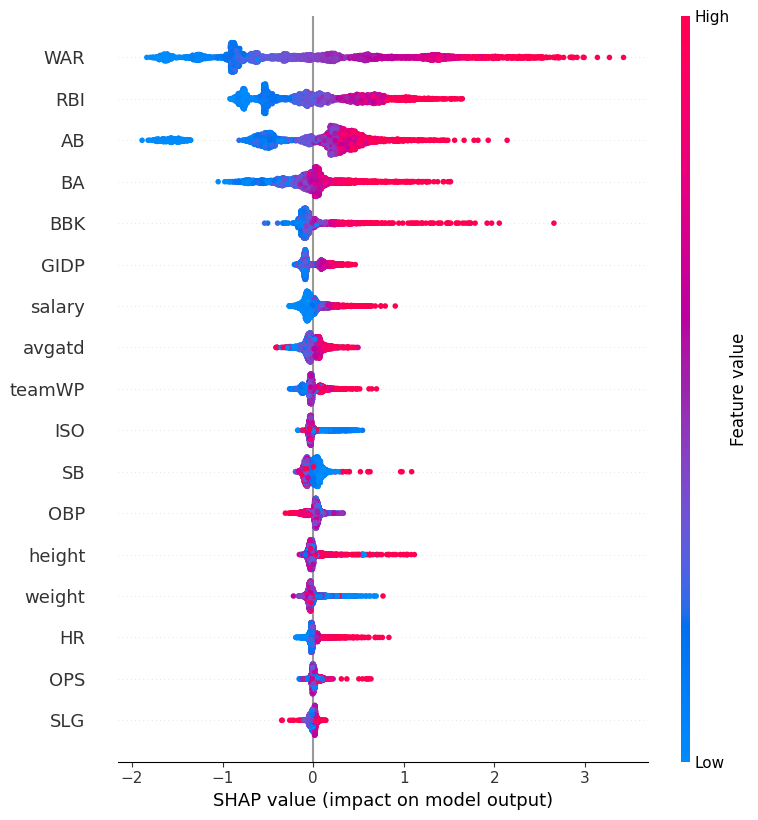

In [ ]:
!pip install shap
import numpy
import shap

clf_best = LGBMClassifier(**lgbm_params)

clf_best.fit(X_trainb, y_trainb)

explainer = shap.TreeExplainer(clf_best)
shap_values = explainer.shap_values(X_testb)
# shap values for survival
#sv_survive = sv[:,y3,:]
# shap values for dying
#sv_die = sv[:,~y3,:]

shap.summary_plot(shap_values[1], X_testb)

WAR -> RBI -> AB

different result from pitcher, almost all values are positively correlated

with the exception of WAR all the top predictors are classsic stats -> different from expected

salary is not that big of an issue, may be due to lack of quality data

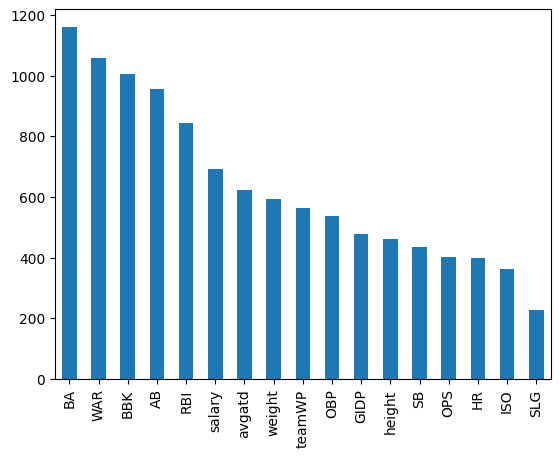

In [ ]:
feature_importances = pd.Series(clf_best.feature_importances_, index=X_trainb.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();

## Pitcher data model

In [ ]:
from skopt.utils import use_named_args

from sklearn.model_selection import train_test_split

auc = np.empty(12)
acc = np.empty(12)

X_trainp, X_testp, y_trainp, y_testp = train_test_split(X_pit, Y_pit, test_size=0.2, random_state=16)

log_params, auc[5], acc[5] = logistic(X_trainp, y_trainp, X_testp, y_testp)

rfe_params, auc[6], acc[6] = rfe(X_trainp, y_trainp, X_testp, y_testp)

rf_params, auc[7], acc[7] = rf(X_trainp, y_trainp, X_testp, y_testp)

lgbm_params, auc[8], acc[8] = lgbm(X_trainp, y_trainp, X_testp, y_testp)

xgb_params, auc[9], acc[9] = xgb(X_trainp, y_trainp, X_testp, y_testp)

svc_params, auc[10], acc[10] = svc(X_trainp, y_trainp, X_testp, y_testp)

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the 

In [ ]:
pit_summary = pd.DataFrame()
pit_summary['auc'] = auc
pit_summary['acc'] = acc

pit_summary

,auc,acc
0,1.072846e-317,0.000000e+00
1,6.663236e-317,4.940656e-324
2,NaN,0.000000e+00
3,1.246364e-316,4.940656e-324
4,NaN,9.881313e-324
5,5.861351e-01,9.014989e-01
6,8.042084e-01,9.224839e-01
7,8.392876e-01,9.289079e-01
8,8.408606e-01,9.323340e-01
9,8.283764e-01,9.280514e-01


In [ ]:
print(lgbm_params)

{'learning_rate': 0.01, 'max_depth': 3, 'num_leaves': 10, 'n_estimators': 1103, 'objective': 'binary'}


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


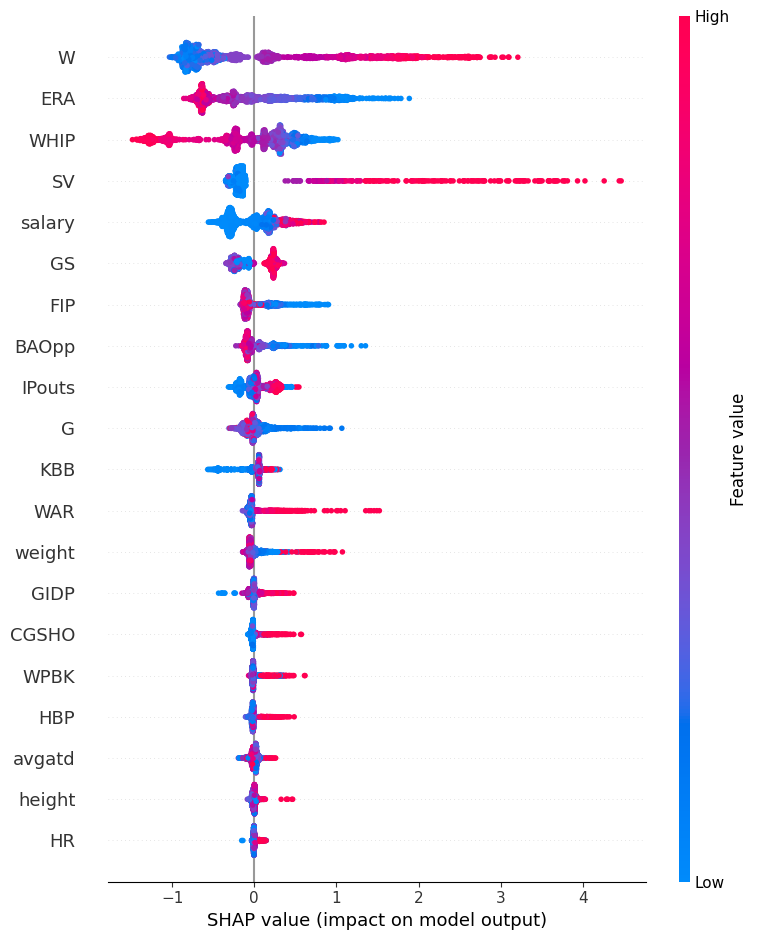

In [ ]:
!pip install shap

import numpy
import shap

clf = LGBMClassifier(learning_rate= 0.01, max_depth= 3, num_leaves= 10, n_estimators= 1103, objective="binary")

clf.fit(X_trainp, y_trainp)

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_testp)
# shap values for survival
#sv_survive = sv[:,y3,:]
# shap values for dying
#sv_die = sv[:,~y3,:]

shap.summary_plot(shap_values[1], X_testp)

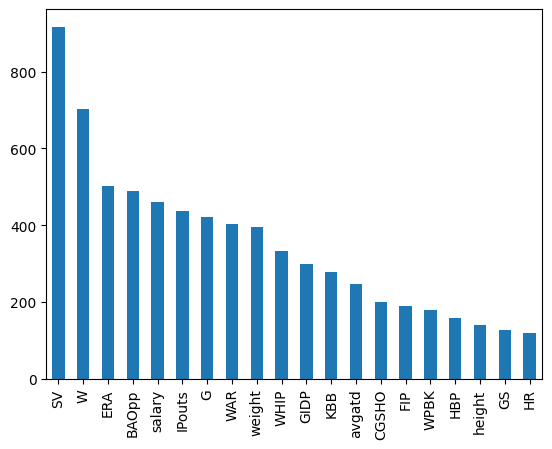

In [ ]:
feature_importances = pd.Series(clf.feature_importances_, index=X_testp.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();

NEED TO ACCOUNT FOR INFLATION IN SALARIES OMG

https://github.com/jldbc/pybaseball/tree/master/docs

https://process-mining.tistory.com/138

https://www.datacamp.com/tutorial/scikit-learn-tutorial-baseball-1

https://www.baseballdatascience.com/category/machine-learning/
need saber data and popularity measure